In [42]:
from finches import Mpipi_frontend, CALVADOS_frontend
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
import localcider
from localcider.sequenceParameters import SequenceParameters

from tqdm import tqdm
import metapredict


import seaborn as sns

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

---
ADs with MED15 tail

In [52]:
ADs = pd.read_csv("data/tf_effectordomains.csv")
ADs = ADs[ADs["Domain type"] == "AD"]
ADs.head()

,Effector domain ID,TF name,TF Family,Domain type,Uniprot ID,Coordinates,Sequence,ENSEMBL gene ID,ENSEMBL protein ID,Assay,Reference (PMID),Notes,N or S?,"Activity (H, M or L)","Confidence (H, M or L)"
2,Effector 0003,AHCTF1,AT hook,AD,Q8WYP5,1445-1698,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,ENSG00000153207,ENSP00000497061,Gal4 DB fusion and luciferase assay,11952839,NaN,S,H,H
4,Effector 0005,AHR,bHLH,AD,P35869,545-848,NLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDLTDEILTYVQDSLS...,ENSG00000106546,ENSP00000242057,LexA DB and Gal4 DB fusions and b-galactosidas...,8794892,NaN,N and S,H,H
5,Effector 0006,AIRE,SAND,AD,O43918,292-545,HQKNEDECAVCRDGGELICCDGCPRAFHLACLSPPLREIPSGTWRC...,ENSG00000160224,ENSP00000291582,Luciferase assay,11274163,NaN,S,M,H
6,Effector 0007,AKAP8L,C2H2 ZF,AD,Q9ULX6,1-384,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,ENSG00000011243,ENSP00000380557,CAT assay,11402034,NaN,N and S,M,H
7,Effector 0008,ALX1,Homeodomain,AD,Q15699,237-281,TSCMLPRDTSSCMTPYSHSPRTDSSYTGFSNHQNQFSHVPLNNFF,ENSG00000180318,ENSP00000315417,Gal4 DB fusion and luciferase assay,12390248,based on rat,S,H,H


In [67]:
cf = CALVADOS_frontend()
mf = Mpipi_frontend()

mpipi_minmax = 2.5
calvados_minmax = 7.5

ticfreq = 2
zero_folded = True

/Users/kinseylong/miniconda3/envs/finches/lib/python3.9/site-packages/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [55]:
med15_seq = "MDVSGQETDWRSTAFRQKLVSQIEDAMRKAGVAHSKSSKDMESHVFLKAKTRDEYLSLVARLIIHFRDIHNKKSQASVSDPMNALQSLTGGPAAGAAGIGMPPRGPGQSLGGMGSLGAMGQPMSLSGQPPPGTSGMAPHSMAVVSTATPQTQLQLQQVALQQQQQQQQFQQQQQAALQQQQQQQQQQQFQAQQSAMQQQFQAVVQQQQQLQQQQQQQQHLIKLHHQNQQQIQQQQQQLQRIAQLQLQQQQQQQQQQQQQQQQALQAQPPIQQPPMQQPQPPPSQALPQQLQQMHHTQHHQPPPQPQQPPVAQNQPSQLPPQSQTQPLVSQAQALPGQMLYTQPPLKFVRAPMVVQQPPVQPQVQQQQTAVQTAQAAQMVAPGVQMITEALAQGGMHIRARFPPTTAVSAIPSSSIPLGRQPMAQVSQSSLPMLSSPSPGQQVQTPQSMPPPPQPSPQPGQPSSQPNSNVSSGPAPSPSSFLPSPSPQPSQSPVTARTPQNFSVPSPGPLNTPVNPSSVMSPAGSSQAEEQQYLDKLKQLSKYIEPLRRMINKIDKNEDRKKDLSKMKSLLDILTDPSKRCPLKTLQKCEIALEKLKNDMAVPTPPPPPVPPTKQQYLCQPLLDAVLANIRSPVFNHSLYRTFVPAMTAIHGPPITAPVVCTRKRRLEDDERQSIPSVLQGEVARLDPKFLVNLDPSHCSNNGTVHLICKLDDKDLPSVPPLELSVPADYPAQSPLWIDRQWQYDANPFLQSVHRCMTSRLLQLPDKHSVTALLNTWAQSVHQACLSAA"

In [59]:
#Get ordered regions of MED15
MED15_obj = metapredict.predict_disorder_domains(med15_seq)
MED15_folded_domain_seqs = MED15_obj.folded_domains
MED15_unfolded_domain_seqs = MED15_obj.disordered_domains

In [68]:
def finches_AD_single_seq(ADsequence_df, refseq, refseqname):
    """
        Input:
        ADsequence_df: DataFrame contaiing sequence of ADs in "Sequence" column
        Refseq: reference sequence to compare against
        Refseqname: string name of the reference sequence
        Return: DF with epsilon scores
    """
    attractive_epsilons = []
    repulsive_epsilons = []
    total_epsilons = []

    for i in range(len(ADsequence_df)):

        seq = ADsequence_df["Sequence"].iloc[i]

        #define window size for short ADs
        window_size = 15
        if len(seq) <= 15 or len(refseq) <= 15:
            window_size = min(len(seq), len(refseq))//3
            
        # Get intralmolecular interaction matrix
        matrix = mf.intermolecular_idr_matrix(seq, refseq, window_size=window_size)[0][0]
        
        # Calculate overall interaction score
        epsilon = mf.epsilon(seq, refseq)
        # Get mean of attractive interactions
        attractive = matrix[matrix < 0].mean()
        # Get mean of repulsive interactions
        repulsive = matrix[matrix > 0].mean()

        attractive_epsilons.append(attractive)
        repulsive_epsilons.append(repulsive)
        total_epsilons.append(epsilon)

    outputdf = pd.DataFrame({refseqname + "_epsilon": total_epsilons, 
                             refseqname + "_attractive": attractive_epsilons, 
                             refseqname + "_repulsive": total_epsilons})

    return outputdf

In [74]:
def makescatterplot(ADsequence_df, refseq, refseqname):
    AD_with_eps = finches_AD_single_seq(ADsequence_df, refseq, refseqname)
    AD_with_eps = pd.concat([ADsequence_df, AD_with_eps], axis=1)
    sns.scatterplot(AD_with_eps, x=refseqname + "_attractive", y=refseqname + "_repulsive", hue="Activity (H, M or L)")
    plt.show()
    return AD_with_eps

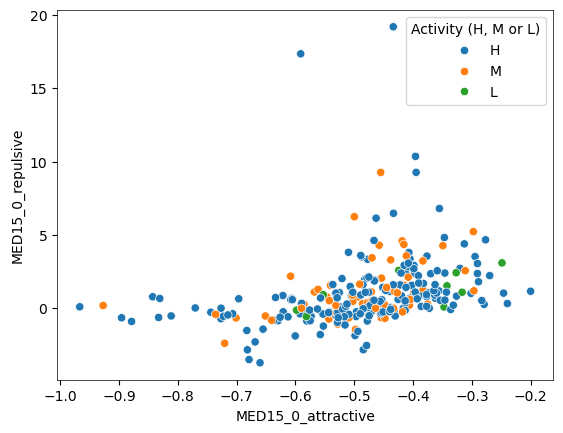

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_72625/3211190216.py:30: RuntimeWarning: Mean of empty slice.
  repulsive = matrix[matrix > 0].mean()
/Users/kinseylong/miniconda3/envs/finches/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


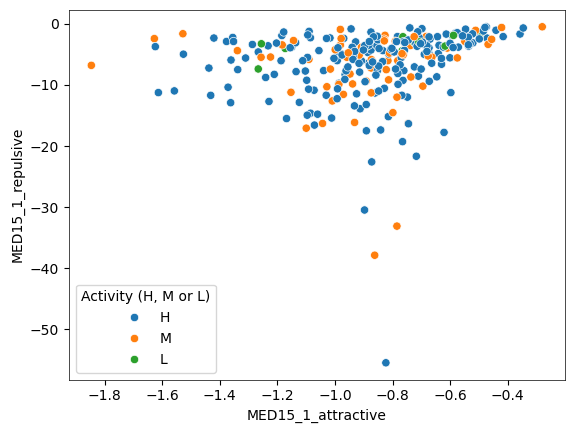

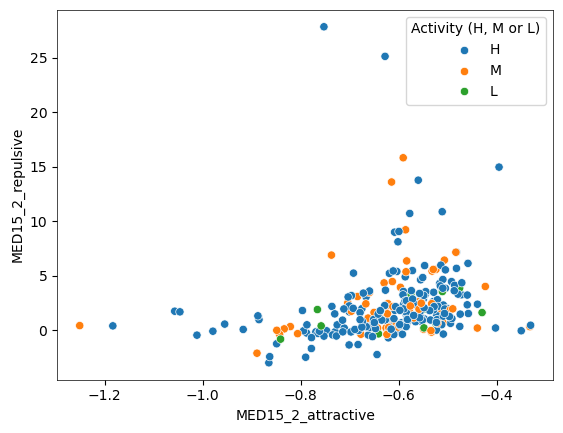

In [ ]:
AD_MED15_1 = makescatterplot(ADs, MED15_folded_domain_seqs[i], "MED15_" + str(i))

In [ ]:
#Run finches on ADs against MED15 ordered regions
ADs_MED15 = ADs.copy()
for i in range(1, len(MED15_folded_domain_seqs) + 1):
    refseqname = "MED15_" + str(i)
    append_df = finches_AD_single_seq(ADs, MED15_folded_domain_seqs[i], refseqname)
    ADs_MED15 = pd.concat([ADs_MED15, append_df])

---

MED12/L interactions

In [4]:
#importing data
def getseq(fasta):
    with open(fasta) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            sequence = record.seq
    return sequence

#sequences of other cofactors
CCNC = getseq("data/CCNC_aa.fasta")
CDK8 = getseq("data/CDK8_aa.fasta")
CDK19 = getseq("data/CDK19_aa.fasta")
MED13 = getseq("data/MED13_aa.fasta")
POL2RA = getseq("data/POLR2A_aa.fasta")
POL2RA_CTD = str(POL2RA)[1592:1960]

In [5]:
#importing MED12 and MED12L IDRs
MED12_IDRs = pd.read_csv("data/MED12_IDRs.csv")
MED12_IDRs["group"] = MED12_IDRs["group"].apply(lambda x: "MED12_IDR_{}".format(str(x)[0]))
MED12_IDRs = MED12_IDRs.sort_values("group").iloc[:7]
MED12_IDRs = MED12_IDRs.drop("Unnamed: 0", axis=1)
MED12_IDRs = MED12_IDRs.set_index("group")[["Sequence"]]

MED12L_IDRs = pd.read_csv("data/MED12L_IDRs.csv")
MED12L_IDRs["group"] = MED12L_IDRs["group"].apply(lambda x: "MED12L_IDR_{}".format(str(x)[0]))
MED12L_IDRs = MED12L_IDRs.sort_values("group").iloc[:7]
MED12L_IDRs = MED12L_IDRs.drop("Unnamed: 0", axis=1)
MED12L_IDRs = MED12L_IDRs.set_index("group")[["Sequence"]]

MED12L_IDRs.head()

,Sequence
group,
MED12L_IDR_1,MAAFGLLSYEQRPLKRPRLGPPDVYPQDPKQKEDELTAVNVKQGFN...
MED12L_IDR_2,SPHMMIGPNNSSIGAPSPGPPGPGMSP
MED12L_IDR_3,GESEVLDEKESISSSSLAGS
MED12L_IDR_4,DLSVTASTRPRSPVGENADEHYSKDHDVKMEIFSPMPGESCENANT...
MED12L_IDR_5,NKKSTTETGVGDEGQKARKNKQE


In [6]:
# Set parameters for finches
cf = CALVADOS_frontend()
mf = Mpipi_frontend()

mpipi_minmax = 2.5
calvados_minmax = 7.5

ticfreq = 2
zero_folded = True
window_size = 15

/Users/kinseylong/miniconda3/envs/finches/lib/python3.9/site-packages/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [7]:
MED12_MED12L_IDRs = pd.concat([MED12_IDRs.loc[["MED12_IDR_3", "MED12_IDR_7"]], MED12L_IDRs.loc[["MED12L_IDR_3", "MED12L_IDR_7"]]])
MED12_MED12L_IDRs

,Sequence
group,
MED12_IDR_3,RCGESEAADEKGSIASGSLSAPSA
MED12_IDR_7,YYLEPLPLPPEDEEPPAPTLLEPEKKAPEPPKTDKPGAAPPSTEER...
MED12L_IDR_3,GESEVLDEKESISSSSLAGS
MED12L_IDR_7,MPKPRSYYLQPLPLPPEEEEEEPTSPVSQEPERKSAELSDQGKTTT...


In [8]:
MED13_disorderobj = metapredict.predict_disorder_domains(str(MED13))
MED13_disordered_seqs = MED13_disorderobj.disordered_domains
MED13_IDRs = pd.DataFrame(index = ["MED13_IDR_{}".format(x) for x in np.arange(1, len(MED13_disordered_seqs) + 1)], data = {"Sequence": MED13_disordered_seqs})
MED13_IDRs

,Sequence
MED13_IDR_1,EEKQEDMDWEDDSLAAVEVLVAGVRMIYPACFVLVPQSDIPTPSPV...
MED13_IDR_2,ELLSSGPSMPFIKEGDGSNMDQEYGTAYTPQTHTSFGMPPSSAPPS...
MED13_IDR_3,LPLDSSLLSQPNLVAPTSQSLITPPQMTNTGNANTPSATLASAASS...
MED13_IDR_4,DSVSTGSVFGRSTTLNMQTSQLNTPQDTSCTHILVFPTSASVQVAS...


In [16]:
def makeplots(IDR_df1, IDR_df2, savefig_dir):
    fig, ax = plt.subplots(len(IDR_df1), len(IDR_df2), figsize=(20,20))

    for i in range(len(IDR_df1)):
        seqname1 = IDR_df1.index.to_list()[i]
        seq1 = IDR_df1["Sequence"][i]
        for j in range(len(IDR_df2)):
            seqname2 = IDR_df2.index.to_list()[j]
            seq2 = IDR_df2["Sequence"][j]
            if min(len(seq1), len(seq2)) < 31:
                windowsizevar = 5
            else:
                windowsizevar = 31
                
            
            values, seq1index, seq2index = mf.intermolecular_idr_matrix(seq1, seq2, window_size=windowsizevar)[0]
            sns.heatmap(pd.DataFrame(index=seq1index, columns=seq2index, data=values).T, ax=ax[j][i], vmax=6, vmin=-6)
            ax[j][i].set_xlabel(seqname1)
            ax[j][i].set_ylabel(seqname2)
    plt.show()
    plt.savefig(savefig_dir, bbox_inches="tight")

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_72625/278996590.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq1 = IDR_df1["Sequence"][i]
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_72625/278996590.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq2 = IDR_df2["Sequence"][j]
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_72625/278996590.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

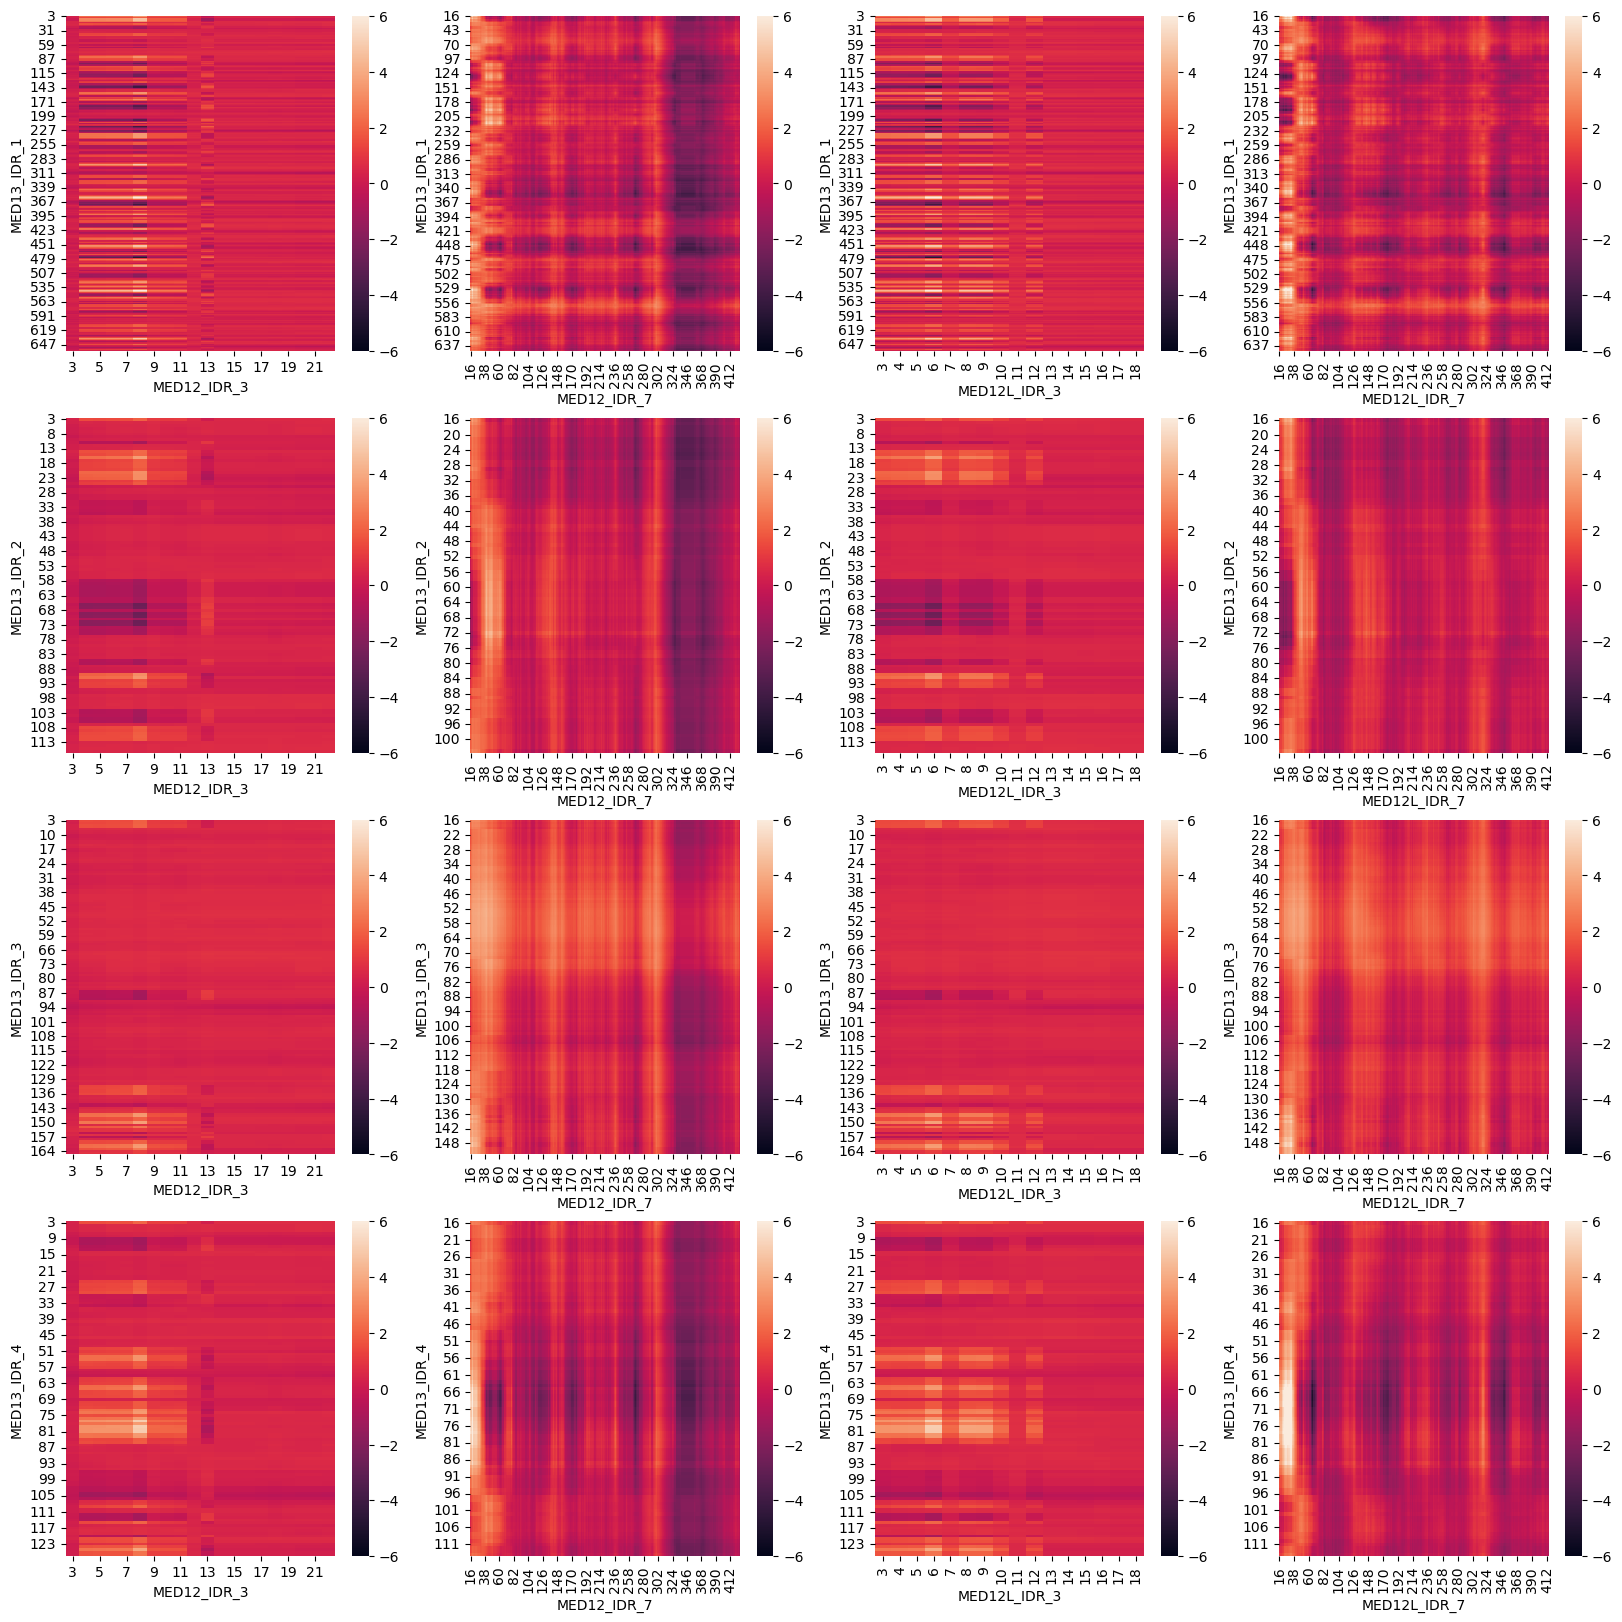

<Figure size 640x480 with 0 Axes>

In [17]:
makeplots(MED12_MED12L_IDRs, MED13_IDRs, "figures/MED12_12L_vs_MED13_IDRs.png")

In [47]:
MED12_IDR_7 = MED12_IDRs.loc["MED12_IDR_7"]["Sequence"]
MED12L_IDR_7 = MED12L_IDRs.loc["MED12L_IDR_7"]["Sequence"]

MED12_IDR_7_310 = SequenceParameters(MED12_IDR_7[310:])
MED12L_IDR_7_320 = SequenceParameters(MED12L_IDR_7[320:])


In [50]:
MED12_IDR_7

'YYLEPLPLPPEDEEPPAPTLLEPEKKAPEPPKTDKPGAAPPSTEERKKKSTKGKKRSQPATKTEDYGMGPGRSGPYGVTVPPDLLHHPNPGSITHLNYRQGSIGLYTQNQPLPAGGPRVDPYRPVRLPMQKLPTRPTYPGVLPTTMTGVMGLEPSSYKTSVYRQQQPAVPQGQRLRQQLQQSQGMLGQSSVHQMTPSSSYGLQTSQGYTPYVSHVGLQQHTGPAGTMVPPSYSSQPYQSTHPSTNPTLVDPTRHLQQRPSGYVHQQAPTYGHGLTSTQRFSHQTLQQTPMISTMTPMSAQGVQAGVRSTAILPEQQQQQQQQQQQQQQQQQQQQQQQQQQYHIRQQQQQQILRQQQQQQQQQQQQQQQQQQQQQQQQQQHQQQQQQQAAPPQPQPQSQPQFQRQGLQQTQQQQQTAALVRQLQQQLSNTQPQPSTNIFGRY'

In [45]:
MED12_IDR_7_310.get_sequence()

'ILPEQQQQQQQQQQQQQQQQQQQQQQQQQQYHIRQQQQQQILRQQQQQQQQQQQQQQQQQQQQQQQQQQHQQQQQQQAAPPQPQPQSQPQFQRQGLQQTQQQQQTAALVRQLQQQLSNTQPQPSTNIFGRY'

In [49]:
MED12L_IDR_7_320.get_sequence()

'PNLPSVPLPQDPMRPRQPQVRQQQRLLQMQQPQQPQPQQPPQPQQSSQSQSQTLGLQAMQPQQPLFPRQGLQQTQQQQQTAALVRQLQKQLSSNQPQQGVTPYGHPSHF'

In [ ]:
MED12L_IDR_7_310

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_15098/657126700.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values, seq1index, seq2index = mf.intermolecular_idr_matrix(MED12L_IDRs["Sequence"][-1], POL2RA_CTD)[0]


Text(50.722222222222214, 0.5, 'POL2RA CTD index')

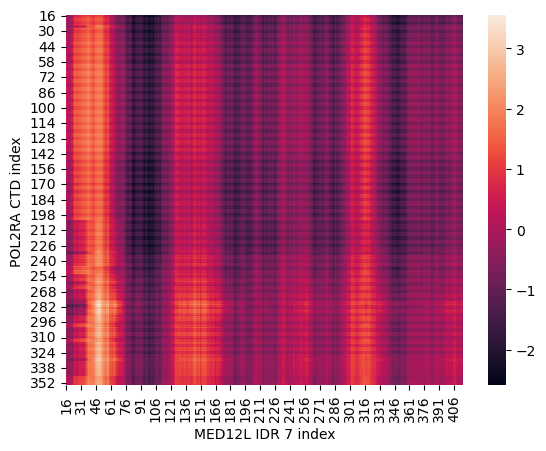

In [60]:
values, seq1index, seq2index = mf.intermolecular_idr_matrix(MED12L_IDRs["Sequence"][-1], POL2RA_CTD)[0]
sns.heatmap(pd.DataFrame(index=seq1index, columns=seq2index, data=values).T)
plt.xlabel("MED12L IDR 7 index")
plt.ylabel("POL2RA CTD index")

In [35]:
#Calculate interactions
def runfinches(seq1, seq2):
    matrix = mf.intermolecular_idr_matrix(seq1, seq2)[0][0]
    # Calculate overall interaction score
    epsilon = mf.epsilon(seq1, seq2)
    # Get mean of attractive interactions
    attractive = matrix[matrix < 0].mean()
    # Get mean of repulsive interactions
    repulsive = matrix[matrix > 0].mean()
    return attractive, repulsive, epsilon

def runfinches_ondf(df, seq2):
    finaldf = df.copy()
    finaldf[['Attractive', 'Repulsive', 'Total']] = finaldf['Sequence'].apply(lambda seq1: pd.Series(runfinches(seq1, seq2)))
    return finaldf

In [40]:
runfinches(MED12L_IDRs["Sequence"][-1], POL2RA_CTD)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_15098/1570539275.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  runfinches(MED12L_IDRs["Sequence"][-1], POL2RA_CTD)


(-0.772975149408013, 0.7450169332185478, -4.298081693256606)

In [42]:
runfinches(MED12L_IDRs["Sequence"][-1], POL2RA_CTD)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_15098/1570539275.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  runfinches(MED12L_IDRs["Sequence"][-1], POL2RA_CTD)


(-0.772975149408013, 0.7450169332185478, -4.298081693256606)

In [44]:
POL2RA_CTD

'YSPTSPAYEPRSPGGYTPQSPSYSPTSPSYSPTSPSYSPTSPNYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPTSPNYSPTSPNYTPTSPSYSPTSPSYSPTSPNYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPSSPRYTPQSPTYTPSSPSYSPSSPSYSPASPKYTPTSPSYSPSSPEYTPTSPKYSPTSPKYSPTSPKYSPTSPTYSPTTPKYSPTSPTYSPTSPVYTPTSPKYSPTSPTYSPTSPKYSPTSPTYSPTSPKGSTYSPTSPGYSPTSPTYSLTSPA'

In [117]:
%%script echo
# Plot the interactions, colored by activity and self interaction

seq_data = seq_data.sort_values("epsilon", ascending=False)
activity = seq_data["Activity_BioRepB_BYS4"]

# Colormap that goes from transparent to red
cmap = mcolors.LinearSegmentedColormap.from_list("TransparentRed", [(1, 1, 1), (1, 0.2, 0)])
norm = plt.Normalize(vmin=activity.min(), vmax=activity.max())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Color by activity
sc1 = axs[0].scatter(
    seq_data["gal11_attractive"], 
    seq_data["gal11_repulsive"], 
    # s=norm(seq_data["Activity_BioRepB_BYS4"]) * 50,
    s=10,
    c=seq_data["Activity_BioRepB_BYS4"], 
    cmap=cmap, 
    edgecolors="black", 
    linewidth=0.25       
)

axs[0].set_xlabel("AD:Gal11 attractive epsilon")
axs[0].set_ylabel("AD:Gal11 repulsive epsilon")

cax = inset_axes(axs[0], width="5%", height="30%", loc="upper left", borderpad=1)
plt.colorbar(sc1, cax=cax, orientation="vertical", label="Activity")

# Colormap from purple to green
cmap = mcolors.LinearSegmentedColormap.from_list("PurpleWhiteGreen", ["purple", "white", "green"])

# Normalize the color scale with zero centered, so white represents zero
max_val = max(abs(seq_data["epsilon"].min()), abs(seq_data["epsilon"].max()))
norm =  plt.Normalize(vmin=-20, vmax=20)

# Second plot: Color by tile self-interaction
sc1 = axs[1].scatter(
    seq_data["gal11_attractive"], 
    seq_data["gal11_repulsive"], 
    # s=norm(seq_data["epsilon"]) * 20,  # Scale size based on color values
    s=10,
    c=seq_data["epsilon"], 
    cmap=cmap, 
    norm=norm,
    edgecolors="black",  # Black outline
    linewidth=0.25        # Adjust outline thickness
)

axs[1].set_xlabel("AD:Gal11 attractive epsilon")
axs[1].set_ylabel("AD:Gal11 repulsive epsilon")

cax = inset_axes(axs[1], width="5%", height="30%", loc="upper left", borderpad=1)
plt.colorbar(sc1, cax=cax, orientation="vertical", label="AD:AD epsilon")

# plt.tight_layout()
plt.show()
